In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

folder_path = '.'
image_file_name = '/images.npy'
label_file_name = '/labels.npy'

images = np.load(folder_path+image_file_name)
images = np.expand_dims(images, axis=-1)
labels = np.load(folder_path+label_file_name)



def shuffle_in_unison(a, b):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for shuffling in unison')
    p = np.random.permutation(len(a))
    return a[p], b[p]

images, labels = shuffle_in_unison(images,labels)

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


18000


In [2]:
def train_test_valid_split(a,b,train=0.8,test=0.1,valid=0.1,shuffle=True,check_data = False):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for splitting in unison')
    total_percentage = train + test + valid
    if total_percentage != 1:
        raise ValueError(f'''Data will not be split correctly \n 
        Total percentage of data used :{total_percentage*100}% \n 
        Training = {train*100}%, testing = {test*100}%, validation = {valid*100}%''')
    if shuffle == True:
        a, b = shuffle_in_unison(a,b)
    
    train_idx = int(len(a)*train)
    test_idx = train_idx+int(len(a)*test)
    valid_idx = len(a)
    train_x = a[:train_idx]
    test_x = a[train_idx:test_idx]
    valid_x = a[test_idx:]
    train_y = b[:train_idx]
    test_y = b[train_idx:test_idx]
    valid_y = b[test_idx:]

    
    if check_data:
        check_len_match = len(train_x) + len(test_x) + len(valid_x)
        print(f'Size of train, test and valid: {len(train_x)},{len(test_x)},{len(valid_x)}')
        if check_len_match == len(a):
            print('yippee')
        else:
            print('no:(')
    
    return train_x, train_y, test_x, test_y, valid_x, valid_y

In [3]:
def check_random_sample(a,b):
    rand_int=np.random.randint(0,len(a))
    plt.imshow(a[rand_int],cmap='gray')
    plt.show()
    if isinstance(b, list):
        hour_label = np.argmax(b[0][rand_int])
        minute_label = np.clip(b[1][rand_int] * 59, 0, 59).astype(int)
        print(f"Hour: {hour_label}, Minute: {minute_label[0]}")
        
    else:
        print(np.argmax(b[rand_int]))

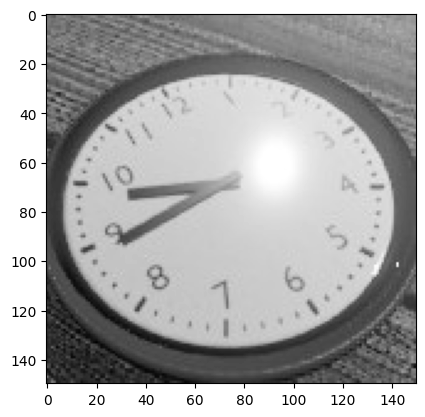

Hour: 9, Minute: 44


In [4]:
from tensorflow.keras.utils import to_categorical
scaler = MinMaxScaler(feature_range=(0, 1))
images = images.astype('float32')/255.0
train_x, train_y, test_x, test_y, valid_x, valid_y = train_test_valid_split(images, labels)


hour_train = to_categorical(train_y[:, 0], num_classes=12)
minute_train = scaler.fit_transform(train_y[:,1].reshape(-1, 1))

hour_valid = to_categorical(valid_y[:, 0], num_classes=12)
minute_valid = scaler.transform(valid_y[:,1].reshape(-1, 1))

train_y=[hour_train,minute_train]
valid_y=[hour_valid,minute_valid]

check_random_sample(train_x,train_y)

In [5]:
# Can use data augmentation to increase the training data set size ie by concatentating a dataset that contatins all the flipped images
# Could also augmentent the data so that all images are alligned in the same direction to remove noise but this may make the model perform worse generally

In [6]:
train_input_dim = (150, 150, 1)
num_hour_classes = 12
print(train_y)
print(num_hour_classes)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0.89830508],
       [0.22033898],
       [0.50847458],
       ...,
       [0.28813559],
       [0.6779661 ],
       [0.96610169]])]
12


In [7]:
import os
import datetime
if os.path.isdir("logs"):
    print('directory exists')
else:
    os.mkdir('./logs')
    os.mkdir('./logs/fit')
if os.path.isdir('models'):
    print('model directory exists')
else:
    os.mkdir('./models')
if os.path.isdir('plots'):
    print('plot directory exists')
else:
    os.mkdir('./plots')
if os.path.isdir('history'):
    print('history directory exists')
else:
    os.mkdir('./history')


directory exists
model directory exists
plot directory exists
history directory exists


In [8]:
from os import listdir
from os.path import isfile, join
def get_iter(path,file_prefix=None):

    files = [f for f in listdir(path) if isfile(join(path, f))]
    iterations = []
    if file_prefix is not None:
        files = [file for file in files if file_prefix in file]

    if not files:
        return 1

    for file in files:
        file = file.split(".", 1)[0]
        try:
            iteration = int(file.split("_")[-1])
            iterations.append(iteration)
        except ValueError:
            continue
    iterations.sort(reverse=True)
    return iterations[0] + 1

In [ ]:
from keras.layers import BatchNormalization

# Cleaned this up because it got quite messy, tried to include residual connections but that ended up overfitting
# Batchnormalization was also added at this point and didn't seem to hurt the model so I left it in
# Removed a bunch of default commands to improve readability
# Dropout of 0.5 was far too much model couldn't learn anything
# Dropout 0.1-0.3 seemed optimal but hard to say with the landscape being so rough

def cnn(input_image_shape=(75,75,1), hour_classes=12):
    inputs = Input(shape=input_image_shape)
    
    # First block
    x = Conv2D(64, (5,5), padding='same', activation='relu', 
               kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    # Second block
    x = Conv2D(96, (3,3), padding='same', activation='relu',
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    # Third block
    x = Conv2D(128, (3,3), padding='same', activation='relu',
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    
    # Fourth block (added depth)
    x = Conv2D(256, (3,3), padding='same', activation='relu',
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    
    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='random_uniform')(x)
    x = Dropout(0.4)(x)
    
    # Outputs - hours classification, minutes regression
    hour_output = Dense(hour_classes, activation='softmax', name='hour_output',kernel_initializer = 'random_uniform')(x)
    minute_output = Dense(1, activation='linear', name='minute_output',kernel_initializer= 'random_uniform')(x)
    
    model = Model(inputs=inputs, outputs=[hour_output, minute_output])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001,clipnorm=1.0),
        loss={
            "hour_output": "categorical_crossentropy",
            "minute_output": 'mae'  
        },
        # Weights to incentivise learning minute over hour as the hour is pretty accurate where as the minute is roughly accurate
        loss_weights={
            "hour_output": 0.5,  
            "minute_output": 5
        },
        metrics={
            "hour_output": "accuracy",
            "minute_output": "mae" 
        }
    )
    return model

In [41]:
path = './models'
iteration = get_iter(path,file_prefix='model')
tf.keras.backend.clear_session()

In [ ]:
# Can get stuck on local minima so need to run like a few times to get a good RNG start

model = cnn(train_input_dim, num_hour_classes)
model.load_weights('./models/good_initialization_14.weights.h5', skip_mismatch=True)

path = './models'
iteration = get_iter(path,file_prefix='model')

epochs = 500
batch_size = 128
model_dir = f"./models/my_model_{iteration}.h5"

callback_list = [EarlyStopping(monitor='val_loss',
                               patience=30,
                               mode='auto',
                               start_from_epoch=40,
                               restore_best_weights=True)]
                #  ReduceLROnPlateau(monitor='val_loss', # May be useful to include this but it was reducing the lr way too soon
                #                    factor = 0.5,
                #                    patience=5,
                #                    min_lr=1e-6,
                #                    mode='auto')]

history = model.fit(    train_x,
                        train_y,
                        epochs=epochs,
                        validation_data=(valid_x, valid_y),
                        callbacks=callback_list,
                        verbose=1,
                        batch_size = batch_size
)

model.save(model_dir)

/vol/home/s4557093/.conda/envs/tf-gpu/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - hour_output_accuracy: 0.9459 - hour_output_loss: 0.1539 - loss: 0.8677 - minute_output_loss: 0.1396 - minute_output_mae: 0.1396 - val_hour_output_accuracy: 0.4806 - val_hour_output_loss: 3.6214 - val_loss: 2.8426 - val_minute_output_loss: 0.1829 - val_minute_output_mae: 0.1864
Epoch 2/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - hour_output_accuracy: 0.9316 - hour_output_loss: 0.1871 - loss: 0.8147 - minute_output_loss: 0.1225 - minute_output_mae: 0.1226 - val_hour_output_accuracy: 0.9039 - val_hour_output_loss: 0.3061 - val_loss: 0.8320 - val_minute_output_loss: 0.1085 - val_minute_output_mae: 0.1095
Epoch 3/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - hour_output_accuracy: 0.9313 - hour_output_loss: 0.1890 - loss: 0.8199 - minute_output_loss: 0.1183 - minute_output_mae: 0.1183 - val_hour_output_accuracy: 0.8644 - val_hour_output_loss: 0.4056 - val_loss: 1.2012 - val_minute_output_loss: 0.1657 - val_minute_output_mae:

In [ ]:
# Decided that using the end point of a good run was useful for consistency 
model.save_weights(f'./models/good_initialization_{iteration}.weights.h5')

# model 12/13 good for 75x75
# Model 14/15 good for 150x150 



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanAbsoluteError, CategoricalAccuracy
custom_objects = {
    'mae': MeanAbsoluteError,
    "MeanAbsoluteError": MeanAbsoluteError,
    "CategoricalAccuracy": CategoricalAccuracy
}

model = load_model('./models/my_model_12.h5', custom_objects = custom_objects)


In [ ]:
hour_pred,minute_pred = model.predict(test_x)
# Really I shouldn't use clip because it introduces bias but I think the bias here is justified as we don't expect 12 to wrap around to 0 and vice versa
minute_pred = np.clip(minute_pred,0,1)
predictions = [hour_pred,minute_pred]


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [46]:

hist_df = pd.DataFrame(history.history)
hist_path=f'./history/history{iteration}.csv'
with open(hist_path, mode='w') as f:
    hist_df.to_csv(f)

print(hist_df.columns)

Index(['hour_output_accuracy', 'hour_output_loss', 'loss',
       'minute_output_loss', 'minute_output_mae', 'val_hour_output_accuracy',
       'val_hour_output_loss', 'val_loss', 'val_minute_output_loss',
       'val_minute_output_mae'],
      dtype='object')


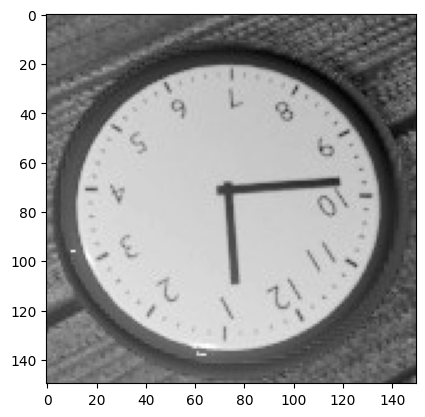

Hour: 0, Minute: 40


In [52]:
check_random_sample(test_x,predictions)

In [47]:
def plot_history_loss(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/loss_history_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'loss_history_model_{iteration}.jpg' 
    plt.savefig(savedir) 
    plt.show() 
    
def plot_history_accuracy(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label]*100,'r-',label='Training') 
    plt.plot(history[second_label]*100,'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy (%)') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/accuracy_history_model_{iteration}.jpg' 
    else: savedir = savedir + 'accuracy_history_model_{iteration}.jpg' 
    plt.savefig(savedir) 
    plt.show() 
    
def plot_history_mae(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Mean absolute error') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/mae_history_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'mae_history_model_{iteration}.jpg' 
    plt.savefig(savedir)
    plt.show() 

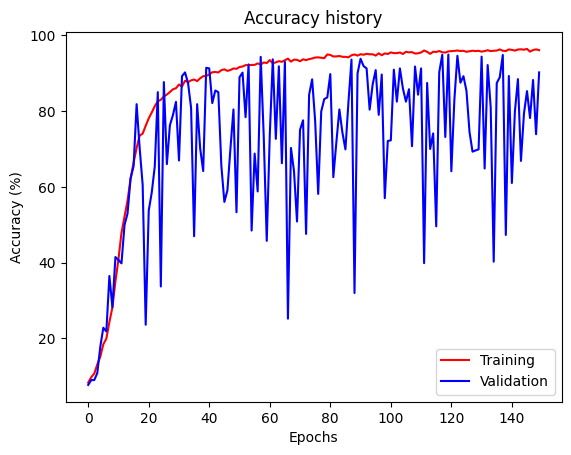

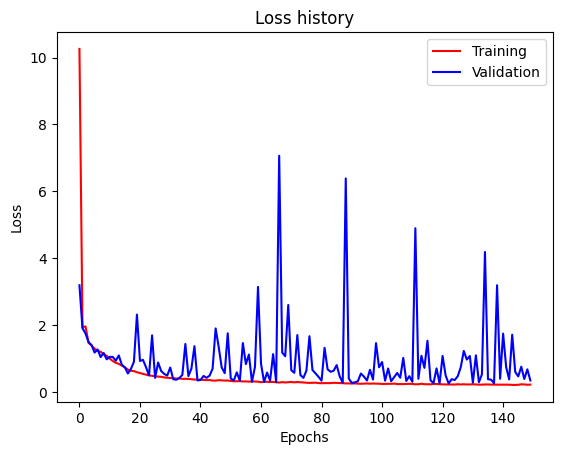

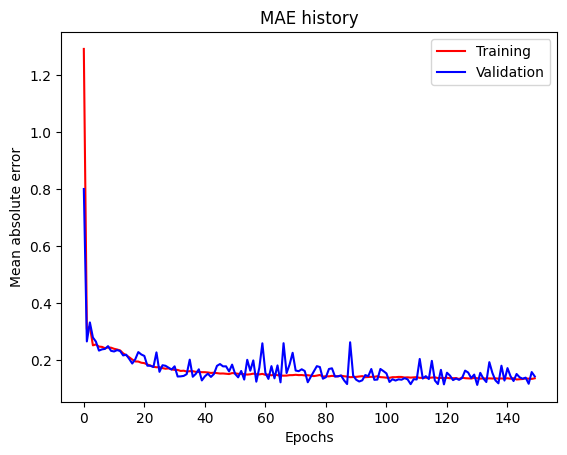

In [37]:
plot_history_accuracy(hist_df,'hour_output_accuracy','val_hour_output_accuracy','Accuracy history')
plot_history_loss(hist_df,'loss','val_loss','Loss history')
plot_history_mae(hist_df,'minute_output_mae','val_minute_output_mae','MAE history')


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score

def plot_predictions(predictions, true_values, savedir = None):
    if savedir is None: 
        savedir = f'./plots/predictions_for_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'predictions_for_model_{iteration}.jpg' 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    axes = axes.flatten()
    fig.suptitle('Predictive Power of the Model')

    hours_true, minutes_true = true_values[:,0], true_values[:,1]
    hours_pred, minutes_pred = tf.argmax(predictions[0], axis=1), np.array(predictions[1]).reshape(-1)
    minutes_pred = (minutes_pred * 59).astype(int)
    minutes_pred = np.clip(minutes_pred, 0, 59).astype(int).flatten()

    cm = confusion_matrix(hours_true, hours_pred)
    acc = accuracy_score(hours_true, hours_pred)
    mae = mean_absolute_error(minutes_true, minutes_pred)
    mse = mean_squared_error(minutes_true, minutes_pred)
    r2 = r2_score(minutes_true, minutes_pred)

    im = axes[0].imshow(cm, cmap='jet')
    axes[0].set_title(f'Hour Confusion Matrix\nAccuracy = {acc*100:.1f}%')
    axes[0].set_xlabel('Predicted hours')
    axes[0].set_ylabel('True hours')
    fig.colorbar(im, ax=axes[0])

    h = axes[1].hist2d(minutes_true, minutes_pred, bins=60, density=False, cmap='jet')
    fig.colorbar(h[3], ax=axes[1])

    axes[1].plot([0, 59], [0, 59], 'k--',lw=3, label='Perfect Prediction')
    axes[1].set_title(f'Minute Prediction 2D Histogram\nMAE={mae:.2f}, MSE={mse:.2f}, R2={r2:.3f}')
    axes[1].set_xlabel('Actual Minute')
    axes[1].set_ylabel('Predicted Minute')
    axes[1].legend()

    plt.savefig(savedir)
    plt.show()
    

3.0494444444444446 25.08388888888889 0.916330357826935


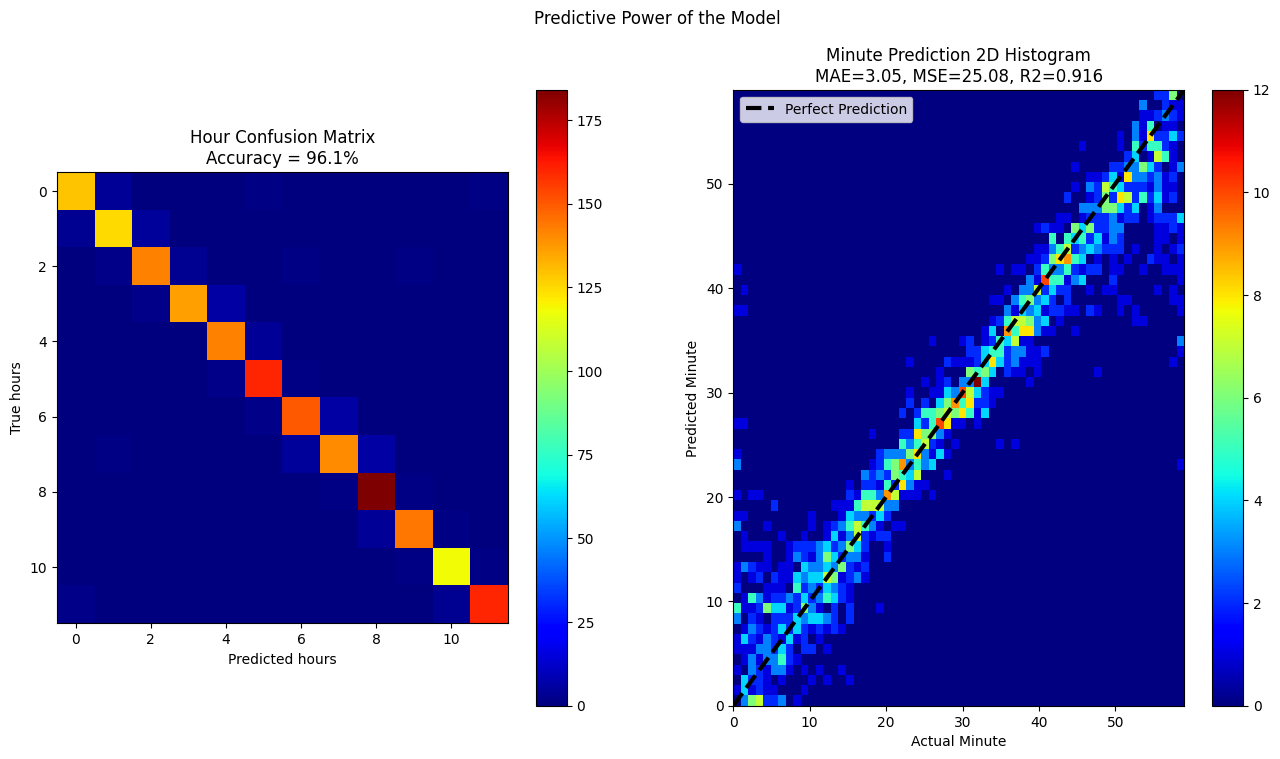

In [49]:
plot_predictions(predictions=predictions,true_values=test_y)